### Schrödingergleichung

$$i\hbar\frac{\partial \psi}{\partial t} = \hat{H} \psi$$

- Für zeitunabhängige Hamiltonoperatoren ist die Zeitentwicklung eines Zustands

    $$\psi(x,t) = \sum_{n=0}^{\infty} c_n e^{-iE_n(t-t_0)/\hbar } \,\phi^{(n)}(x), \quad c_n = \langle \phi^{(n)}|\psi(t_0)\rangle$$

    mit orthogonalen Eigenzuständen $\phi^{(n)}$ und reellen Energieeigenwerten $E_n$ als Lösung der stationären Schrödingergleichung

    $$\hat{H}\phi = E\phi$$

### Eigenzustände numerisch

Räumlich beschränktes Teilchen in 1D

$$\hat{H} = -\frac{\hbar^2}{2m}\frac{\mathrm{d}^2}{\mathrm{d}x^2} + V(x)$$

$$\phi(0) = \phi(L) = 0$$

$$\langle\phi|\psi\rangle = \int_0^L \phi^*(x) \psi(x) \mathrm{d}x$$

- Dimensionslose Größen ($x' = x / L, t' = \frac{t}{mL^2}, V' = mL^2V, E' = mL^2E$, wobei im Folgenden $'$ weggelassen) und Konvention $\hbar=1$:

    $$\left[-\frac{1}{2}\frac{\mathrm{d}^2}{\mathrm{d}{x}^2} + V(x)\right]\mathclose{}\phi(x) = E\phi(x)$$

    $$\phi(0) = \phi(1) = 0$$

- Diskretisierung ($\phi_j \approx \frac{\phi_{j-1}-2\phi_j+\phi_{j+1}}{\Delta x^2}$ mit $\phi_j = \phi(j\Delta x);\: \phi_0 = \phi_N = 0;\: \Delta x = 1/N$ ) ergibt ein lineares System mit tridiagonaler Matrix:

    $$
    \begin{bmatrix}\frac{1}{\Delta x^2}+V_1 & -\frac{1}{2 \Delta x^2} & \hphantom{\frac{1}{\Delta x^2}+V_1} &\\[10pt]
    -\frac{1}{2 \Delta x^2} & \ddots & \ddots &\\[10pt]
    & \ddots & \ddots & -\frac{1}{2 \Delta x^2}\\[10pt]
    & \hphantom{\frac{1}{\Delta x^2}+V_1} & -\frac{1}{2 \Delta x^2} & \frac{1}{\Delta x^2}+V_{N-1}\end{bmatrix}
    \begin{bmatrix} \phi_1 \\ \vdots \\ \phi_{N-1} \end{bmatrix} = E \begin{bmatrix} \phi_1 \\ \vdots \\ \phi_{N-1} \end{bmatrix}
    $$

- Lösung des Eigenproblems und Zeitentwicklung:

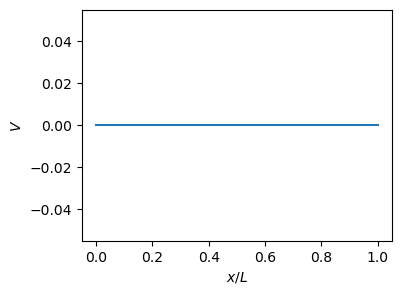

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.integrate import quad
import plotly.graph_objects as go

class TISE1d:
    def __init__(self, V):
        """
        Stationäre Schrödingergleichung in 1D für ein gegebenes Potential.

        Parameters:
        -----------
        V : callable
            Potential V(x) für x in [0, 1].
        """
        self.V = np.vectorize(V)
        self.x, self.E_n, self.phi_n = self.eigenstates()
    
    def eigenstates(self, N=500):
        """
        Lösung für ein räumlich beschränktes Teilchen.

        Parameters:
        -----------
        N : int, optional (default=500)
            Anzahl der Diskretisierungspunkte.
        
        Returns:
        --------
        x : numpy.ndarray, shape (N,)
            Positionen.
        E_n : numpy.ndarray, shape (N-2,)
            Energieeigenwerte.
        phi_n : numpy.ndarray, shape (N-2, N)
            Eigenzustände phi_n(x) in Zeilen.
        """
        N -= 1
        dx = 1 / N
        x = np.linspace(0, 1, N+1)
        d = 1/dx**2 + np.vectorize(self.V)(x[1:-1]) # diagonal
        e = np.full(len(d)-1, -1/(2*dx**2)) # off-diagonal
        E_n, phi_n = eigh_tridiagonal(d, e)
        phi_n = np.pad(phi_n.T, ((0, 0), (1, 1))) # include boundary values
        return x, E_n, phi_n
    
    def _animation(self, t, psi):
        fig = go.Figure()
        # Add traces and steps for time-slider
        steps = []
        for i, t_i in enumerate(t):
            fig.add_trace(
                go.Scatter(
                    visible=False,
                    name=f'$|\psi(x, t={t_i:.1f})|$',
                    x=self.x,
                    y=np.abs(psi[:,i]),
                    line=dict(color='rgb(31, 119, 180)')
                )
            )

            visible = [False] * len(t)
            visible[i] = True
            step = dict(
                method="update",
                args=[{"visible": visible}, {"title": f"Wellenfunktion."}],
                label=f'{t_i:.1f}'
            )
            steps.append(step)
            
        """
        # Add plot of func as last trace
        fig.add_trace(
            go.Scatter(
                visible=True,
                name=rf'${func_name}$',
                x=xx,
                y=func(xx),
                line=dict(color='rgb(255, 127, 14)')
            )
        ) 
        """

        # Create slider
        slider = go.layout.Slider(
            currentvalue = {"prefix": "t: "},
            pad = {"t": 50},
            steps = steps
        )

        fig.update_layout(
            sliders=[slider],
            title="",
            showlegend=True,
            yaxis=dict(range=[min(np.min(psi.real), np.min(psi.imag)), max(np.max(psi.real), np.max(psi.imag))])
            )

        fig.show() # fig.write_html(f"ani.html", include_mathjax='cdn')

    def time_evolution(self, psi0, t_span=(0,100), dt=1, animation=True):
        """
        Zeitentwicklung eines Zustandes.

        Parameters:
        -----------
        psi0 : numpy.ndarray, shape (N,)
            Anfangszustand psi0(x) zum Zeitpunk t0.
        t_span : tuple, optional (default=(0,100))
            Zeitintervall [t0, tend).
        dt : float, optional (default=0.1)
            Zeitschritt.
        animation : bool, optional (default=True)
            Show animation.

        Returns:
        --------
        t : numpy.ndarray, shape (len(t),)
            Zeitpunkte, an denen Wellenfunktion ausgewertet wurde.
        psi : numpy.ndarray, shape (N, len(t))
            Wellenfunktion psi(x, t).
        """
        t = np.arange(*t_span, dt)
        c_n = np.dot(self.phi_n, np.conjugate(psi0))
        c_nt = c_n.reshape(-1, 1) * np.exp(-1j * self.E_n.reshape(-1, 1) * t)
        psi = self.phi_n.T @ c_nt 
        if animation:
            self._animation(t, psi)
        return t, psi

def V(x, mu=0.7, sigma=0.05):
    return -1e4 * np.exp(-(x - mu)**2 / (2*sigma**2))

def V(x):
    return 0

sol = TISE1d(V)

plt.figure(figsize=(4,3))
plt.plot(sol.x, sol.V(sol.x))
plt.xlabel('$x/L$')
plt.ylabel('$V$')
plt.show()

def psi0(x):
    return np.exp(-(x - 0.5)**2 / (2 * 0.1**2))

def norm(psi, x_range=(0,1)):
    integral, _ = quad(lambda x: np.abs(psi(x))**2, *x_range)
    return np.sqrt(integral)

def wave_packet(x, mu=0.5, sigma=0.1, p=0):
    return 1/(2*np.pi*sigma**2)**(1/4) * np.exp(-(x-mu)**2 / (4*sigma**2) - 1j*p*x)

t, psi = sol.time_evolution(wave_packet(sol.x) / norm(wave_packet))

In [2]:
""" def norm(phi):
    norm = np.sum(np.square(np.abs(phi)))*deltax
    return phi/np.sqrt(norm) """

## TODO

- https://lukepolsonphysicsblog.wordpress.com/2020/10/29/example-post-3/; https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid17.ipynb
- finish _animate from sheet3 CP2 - interactive widgets
    - plot real and imag + betragsquadrat
    - check range/ylims
- check norm with sympy
- use mercury for interactive website?

- WAVEPACKET ANIMATION SEPERATE FROM EIGENSTATES and on [-inf, inf] instead of [-1, 1] (proper Norm)

    - wave_packet: https://www.taheramlaki.com/blog/articles/quantum-particles/

    - anim1: https://ben.land/post/2022/03/09/quantum-mechanics-simulation/

    - anim2: https://jakevdp.github.io/blog/2012/09/05/quantum-python/

    - methods: https://arxiv.org/pdf/1607.01714.pdf

    - time evolution of eigenstate - stationary prob. - like in this plot: https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation#Time-independent_equation

- eigenstate limits x [-1, 1]: https://hackernoon.com/how-to-solve-for-eigenstates-a-time-independent-schrodinger-equation-5q1h34on

    - TODO: check tridiag matrix


- Example potentials: harmonic osci, [Morse](https://de.wikipedia.org/wiki/Morse-Potential)
    - solve Morse: file:///C:/Users/User/Downloads/Scientific_Paper%20(1).pdf

- plotly autoplay animation

In [3]:
""" import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input fields to change paramters of plot and a button to display interp_animation

input_widget_func = widgets.Text(
    value='sin(x) / (1 + 25 * x**2)',
    placeholder='Enter sympy expression here...',
    description='Function:')

input_widget_N = widgets.Text(
    value='60',
    placeholder='Enter max. number of nodes here...',
    description='N_max:')

input_widget_ylims = widgets.Text(
    value='[-0.12, 0.12]',
    placeholder='[ymin,ymax] or empty for automatic...',
    description='ylims:')

button_widget = widgets.Button(description='Run & wait a sec.')

waiting_widget = widgets.HTML(value="")

def run_code(_):
    # Clear previous output
    clear_output()

    # Retrieve the text entered by the user
    func_str = input_widget_func.value
    N_str = input_widget_N.value
    # Parse the function using sympy
    import sympy as sp
    x_sym = sp.symbols('x')
    expr = sp.parse_expr(func_str)
    latex_expr = sp.latex(expr)
    func = sp.lambdify(x_sym, expr)

    # Executed code
    display(input_widget_func, input_widget_N, input_widget_ylims, button_widget)
    waiting_widget.value = "Waiting..."
    display(waiting_widget)

    ylims = input_widget_ylims.value
    parsed_ylims = None
    if ylims != '':
        try: 
            parsed_ylims = eval(ylims)
        except: pass
    interp_animation(func, latex_expr, N_max=int(N_str), ylims=parsed_ylims)

    waiting_widget.value = "Use slider to increase degree of the Lagrange interpolant; run again with different parameters..."
    

# Assign the run_code function to the button's on_click event
button_widget.on_click(run_code)

# Display the widgets
display(input_widget_func, input_widget_N, input_widget_ylims, button_widget) """

' import ipywidgets as widgets\nfrom IPython.display import display, clear_output\n\n# Create input fields to change paramters of plot and a button to display interp_animation\n\ninput_widget_func = widgets.Text(\n    value=\'sin(x) / (1 + 25 * x**2)\',\n    placeholder=\'Enter sympy expression here...\',\n    description=\'Function:\')\n\ninput_widget_N = widgets.Text(\n    value=\'60\',\n    placeholder=\'Enter max. number of nodes here...\',\n    description=\'N_max:\')\n\ninput_widget_ylims = widgets.Text(\n    value=\'[-0.12, 0.12]\',\n    placeholder=\'[ymin,ymax] or empty for automatic...\',\n    description=\'ylims:\')\n\nbutton_widget = widgets.Button(description=\'Run & wait a sec.\')\n\nwaiting_widget = widgets.HTML(value="")\n\ndef run_code(_):\n    # Clear previous output\n    clear_output()\n\n    # Retrieve the text entered by the user\n    func_str = input_widget_func.value\n    N_str = input_widget_N.value\n    # Parse the function using sympy\n    import sympy as sp\n

In [2]:
#! pip install plotly
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
                 size="pop", color="continent", hover_name="country",
                 log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])
# Save locally as fig.show() is not working in jupyterlab without extension
fig.write_html("my_visualisation.html")
from IPython.display import HTML
HTML(filename="my_visualisation.html")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, integrate
import pandas as pd

def wavepacket(x, mu=0.5, sigma=0.1, k=1):
    return np.exp(1j*k*x - (x - mu)**2 / (4*sigma**2)) / np.sqrt((2*np.pi)**0.5 * sigma)

def potential(x):
    return (x - 0.5)**2

L = 1
delta_x = 0.01
x = np.arange(0, L+delta_x, delta_x)
N = x.size

V = potential(x)

D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / delta_x**2

def rhs(t, psi, D2, V, hbar=1, m=1):
    return -1j/hbar * (-hbar**2 / (2*m) * D2 @ psi + V * psi)

delta_t = 0.01
t_span = (0, 1)
t = np.arange(*t_span, delta_t)
psi0 = wavepacket(x)
sol = integrate.solve_ivp(rhs, t_span=t_span, y0=psi0, t_eval=t, args=(D2, V))

In [ ]:
def animation(x, t, Y, title='Wavepacket time evolution'):
    "Plot Y (shape (len(x), len(t)) and complex) with slider for t. "
    prob = np.abs(Y)**2
    N = len(t)
    fig = go.Figure()
    steps = []
    for i in range(N):
        fig.add_trace(go.Scatter(visible=False, name=rf'$|\psi(x, t={t[i]:.1f})|^2$', x=x, y=prob[:,i], line=dict(color='rgb(31, 119, 180)')))
        visible = [False] * (N+1)
        visible[i] = True
        visible[-1] = True
        step = dict(
            method="update",
            args=[{"visible": visible}, {"title": f"{title} ($t={t[i]:.1f}$)."}],
            label=t[i]
        )
        steps.append(step)
        
    # Last trace is always visible
    fig.add_trace(go.Scatter(visible=True, name=r'$|\psi(x, 0)|^2$', x=x, y=prob[:,0], line=dict(color='rgb(255, 127, 14)')))

    # Create slider
    slider = go.layout.Slider(
        currentvalue = {"prefix": "t: "},
        pad={"t": 50},
        steps=steps
    )
    
    fig.update_layout(
        sliders=[slider],
        title="",
        showlegend=True,
        yaxis=dict(range=(np.min(prob), np.max(prob))),
        )

    return fig 

fig = animation(x, sol.t, sol.y)
HTML(fig.to_html()) # fig.show() not working in jupyterlab
#fig.write_html('plot.html', include_mathjax='cdn')